## Non-Linear Regressions
- Nonlinear regression is a form of regression analysis in which model is fit to data and then expressed as a mathematical function.
- Simple Linear Regression relates two variables (X and Y) with a straight line (y = mx + b)
- Non-linear Regression relates the two variables in a nonlinear (curved) relationship.

I'll import the most important libraries and the dataset.

In [1]:
# import libraries
# ofr data
import pandas as pd
import numpy as np
import scipy

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for machine learning
from sklearn import model_selection, preprocessing, feature_selection, metrics, decomposition, neighbors, tree, ensemble, neural_network
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv("/home/znagy2/data_development/notebooks/ML_practice/input/boston.csv")

### 8. K-Nearest Neighbors (KNN) Regression
- Regression based on k-nearest neighbors.
- The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

In [3]:
# split dataset
X = data.drop(["MEDV"],axis=1)
y = data["MEDV"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=1)

In [4]:
# call and train model
knn_regressor = neighbors.KNeighborsRegressor().fit(X_train, y_train)
# get default neighbors number
print("Default neighbor number: ", knn_regressor.n_neighbors)

Default neighbor number:  5


I'll make a prediction and print the performance metrics.

In [5]:
y_pred = knn_regressor.predict(X_test)
# print metrics
print("Test data - MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("Test data - RMSE: ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test data - MSE:  44.914613157894735
Test data - RMSE:  6.701836551117517


From the prediction point of view, the k or n_neighbors has a huge importance, I'll evaluate it:

In [6]:
MSE=[]
RMSE=[]

for k in range(10):
    k=k+1
    knn_regressor = neighbors.KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)
    y_pred = knn_regressor.predict(X_test)
    mse = metrics.mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)
    print("k = ", k, " MSE: ", mse," RMSE: ", rmse)

k =  1  MSE:  52.85842105263158  RMSE:  7.270379704845654
k =  2  MSE:  42.8475  RMSE:  6.545800180268261
k =  3  MSE:  39.92437865497076  RMSE:  6.318574099824324
k =  4  MSE:  42.10359786184211  RMSE:  6.488728524282867
k =  5  MSE:  44.914613157894735  RMSE:  6.701836551117517
k =  6  MSE:  45.13749086257311  RMSE:  6.718444080482706
k =  7  MSE:  44.90834452201934  RMSE:  6.701368854347546
k =  8  MSE:  44.98314247532895  RMSE:  6.706947329100546
k =  9  MSE:  46.755018680961655  RMSE:  6.837764158038917
k =  10  MSE:  45.713972368421054  RMSE:  6.761210865549236


I'll use the GridSearch to find the best k hyperparameter.

In [7]:
# create sample space
knn_params = {"n_neighbors": np.arange(1,30,1)}
# call KNN model
knn = neighbors.KNeighborsRegressor()
# call GridSearch model
knn_gridSearch = model_selection.GridSearchCV(knn, knn_params, cv=10).fit(X_train, y_train)
# print the optimal k number
print("Optimal k number: ", knn_gridSearch.best_params_)

Optimal k number:  {'n_neighbors': 3}


We can conclude the the optimal k number is 3 in our case.

I'll create a tuned model with the optimal hyperparameter.
I'll write a function to improve reusability.

In [8]:
def tuned_mode_plotter(tuned_model):
    # tuned prediction
    y_pred_tuned = tuned_model.predict(X_test)
    # print metrics
    print("Test data - MSE: ", metrics.mean_squared_error(y_test, y_pred_tuned))
    print("Test data - RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred_tuned)))
    print("Test data - Pearson's R: ", scipy.stats.pearsonr(y_test.values, y_pred_tuned)[0])
    pearson_cc = "Pearson's R = " + str(round(scipy.stats.pearsonr(y_test.values, y_pred_tuned)[0], 2))
    # plotting
    # initialize layout
    fig, ax = plt.subplots(figsize = (9, 9))
    # add scatterplot
    ax.scatter(y_test, y_pred_tuned)
    b, a = np.polyfit(y_test, y_pred_tuned, deg=1)
    # create sequence from 0 to 50
    xseq = np.linspace(0, 50, num=100)
    ax.plot(xseq, a + b * xseq, color="k", lw=2.5)
    # plot R2
    plt.text(0, 47.5, pearson_cc, size=26)
    # plot axis labels
    plt.xlabel("Measured data")
    plt.ylabel("Calculated data")

Test data - MSE:  39.92437865497076
Test data - RMSE:  6.318574099824324
Test data - Pearson's R:  0.756425996849301


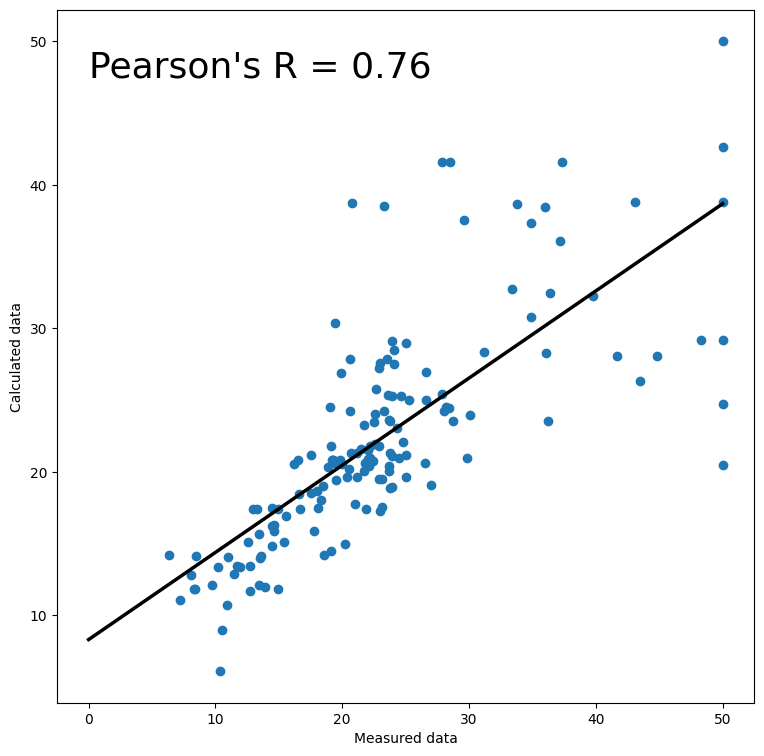

In [9]:
knn_regressor_tuned = neighbors.KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)
# use plotter function
tuned_mode_plotter(knn_regressor_tuned)

### 9. Decision Tree
- The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.
- A tree can be seen as a piecewise constant approximation.

In [10]:
# call model and training
regg_tree = tree.DecisionTreeRegressor(max_leaf_nodes=10).fit(X_train, y_train)

In [11]:
# make a prediction
y_pred = regg_tree.predict(X_test)
print("Test data - MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("Test data - RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test data - MSE:  11.529191173169666
Test data - RMSE:  3.3954662674174316


Decision trees are sensitive to overfitting. I'll tune the hyperparameters, I'll focus on:
- max_leaf_nodes – Maximum number of leaf nodes a decision tree can have
- min_samples_split – Minimum number of samples a node must possess before splitting.

In [12]:
# create sample space
regg_tree_params = {
    "min_samples_split":range(2, 7),
    "max_leaf_nodes":range(2, 7)
}
# call GridSearch cross validator
regg_tree_gridSearch = model_selection.GridSearchCV(regg_tree, regg_tree_params, cv=10)
# run GridSearch
regg_tree_gridSearch.fit(X_train, y_train)
# print the optimal hyperparameters
print(regg_tree_gridSearch.best_params_)

{'max_leaf_nodes': 6, 'min_samples_split': 2}


Test data - MSE:  17.54124215726587
Test data - RMSE:  4.188226612453756
Test data - Pearson's R:  0.9005111742195888


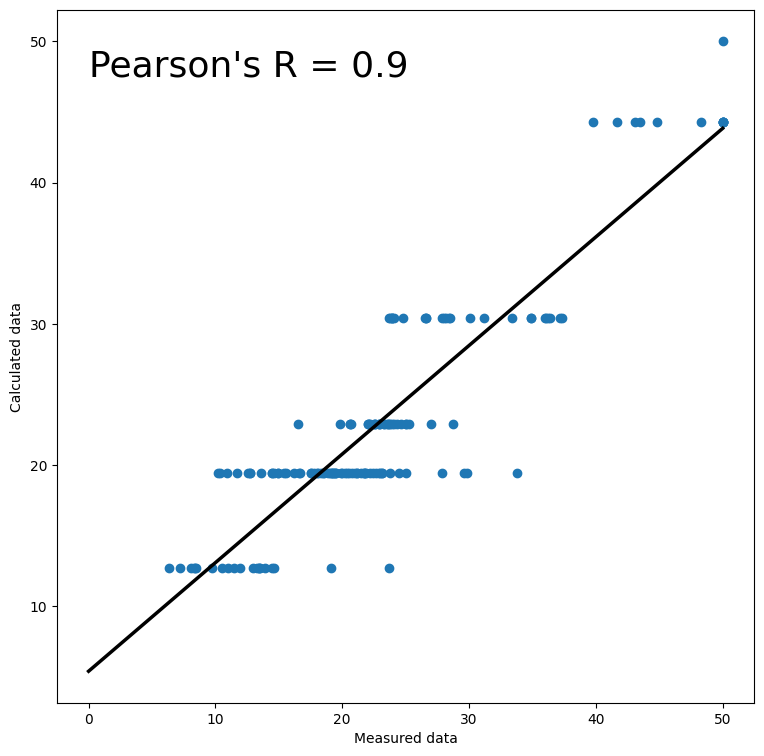

In [13]:
regg_tree_tuned = tree.DecisionTreeRegressor(max_leaf_nodes=6, min_samples_split=5).fit(X_train, y_train)
# use plotter function
tuned_mode_plotter(regg_tree_tuned)

### 10. Random Forest
Decision trees are sensitive to input data variance, so we should try to avoid overfitting. Random forest evaluates the predictions produced by multiple decision trees by bringing them together. Parallel application of several decision trees reduce the risk of overfitting.

In [14]:
# call model
rf_model = ensemble.RandomForestRegressor(random_state=1)
# train model
rf_model.fit(X_train, y_train)
# make a prediction
y_pred = rf_model.predict(X_test)
# print performance metrics
print("Test data - MSE: ", metrics.mean_squared_error(y_pred, y_test))
print("Test data - RMSE: ", np.sqrt(metrics.mean_squared_error(y_pred, y_test)))

Test data - MSE:  8.490417302631574
Test data - RMSE:  2.9138320649329765


I'll tune the hyperparameters:
- max_depth - I can limit up to what depth I want every tree in my random forest to grow.
- max_features - This resembles the number of maximum features provided to each tree in a random forest.
- n_estimators - The number of decision tres that build up the random forest.

Theses hyperparameters are just examples, I just pick them out from the whole list (min_sample_split, max_leaf_nodes, min_samples_leaf, max_sample).

In [15]:
# sample space
rf_params={
    "max_depth":list(range(1,10)),
    "max_features":[3,5],
    "n_estimators":[100,200]
}
# call GridSearch cross validator
rf_gridSearch = model_selection.GridSearchCV(rf_model, rf_params, cv=10)
# apply GridSearch
rf_gridSearch.fit(X_train, y_train)
# print the best hyperparameters
rf_gridSearch.best_params_

{'max_depth': 9, 'max_features': 5, 'n_estimators': 200}

Test data - MSE:  9.068514445876103
Test data - RMSE:  3.011397424099998
Test data - Pearson's R:  0.9589554525064403


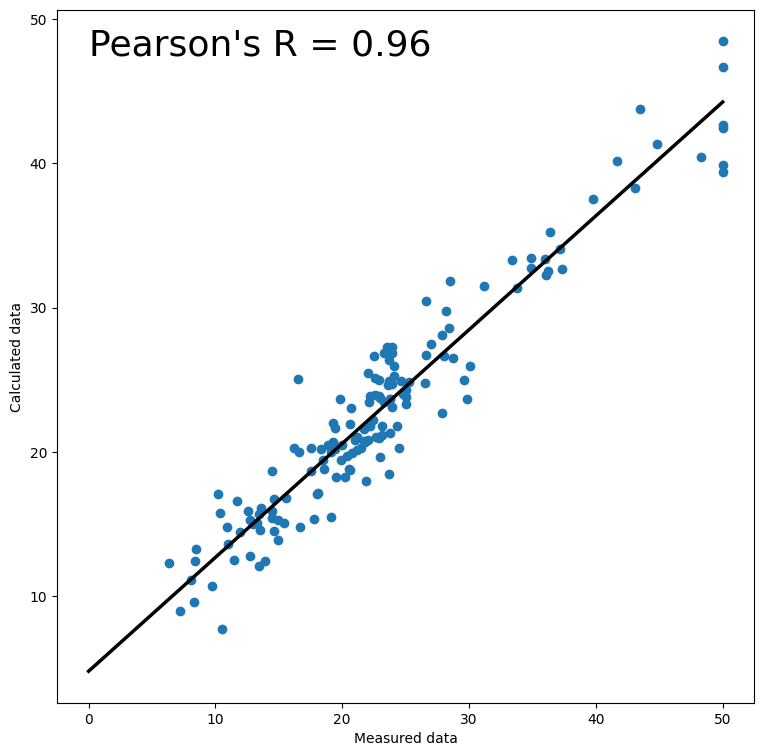

In [16]:
rf_model_tuned = ensemble.RandomForestRegressor(random_state=1, max_depth=9, max_features=5, n_estimators=200).fit(X_train, y_train)
# use plotter function
tuned_mode_plotter(rf_model_tuned)

## Gradient Boosting
It gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees. When a decision tree is the weak learner, the resulting algorithm is called gradient-boosted trees; it usually outperforms random forest.
Advantages:
- able to handle tabular datasets
- can deal with missing values, outliers, and high cardinality categorical values

### 11. Adaptive Boosting (AdaBoost)
- The most common algorithm used with AdaBoost is decision trees with one level that means with Decision trees with only 1 split. These trees are also called Decision Stumps.
- What this algorithm does is that it builds a model and gives equal weights to all the data points. It then assigns higher weights to points that are wrongly perform. Now all the points which have higher weights are given more importance in the next model. It will keep training models until and unless a lowe error is received.

In [17]:
# call and train model
adaBoost_model = ensemble.GradientBoostingRegressor().fit(X_train,y_train)
# make a prediction
y_pre = adaBoost_model.predict(X_test)
# print performance metrics
print("Test data - MSE: ", metrics.mean_squared_error(y_pred, y_test))
print("Test data - RMSE: ", np.sqrt(metrics.mean_squared_error(y_pred, y_test)))

Test data - MSE:  8.490417302631574
Test data - RMSE:  2.9138320649329765


GBM has severla hyperparameters, which can be collected into these bigger groups:
- Tree-Specific Parameters: These affect each individual tree in the model.
- Boosting Parameters: These affect the boosting operation in the model.
- Miscellaneous Parameters: Other parameters for overall functioning.

I'll tune the learning_rate, max_depth, n_estimators, subsample hyperparameters.

In [18]:
# parameter space
adaBoost_params = {
    "learning_rate":[0.001,0.01],
    "max_depth":[3,5],
    "n_estimators":[200,500],
    "subsample":[1,0.5]
}
# call GridSearch and find optimal hyperparameter
adaBoost_gridSearch = model_selection.GridSearchCV(adaBoost_model, adaBoost_params, cv=10, verbose=2, n_jobs=-1).fit(X_train,y_train)
# print optimal parameters
print(adaBoost_gridSearch.best_params_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, subsample=1; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, subsample=1; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, subsample=1; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, subsample=1; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, subsample=1; total time=   0.3s[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.2s

[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, subsample=1; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, subsample=1; total time=   0.3s
[

Test data - MSE:  7.505147833873475
Test data - RMSE:  2.739552487884376
Test data - Pearson's R:  0.9618310108964079


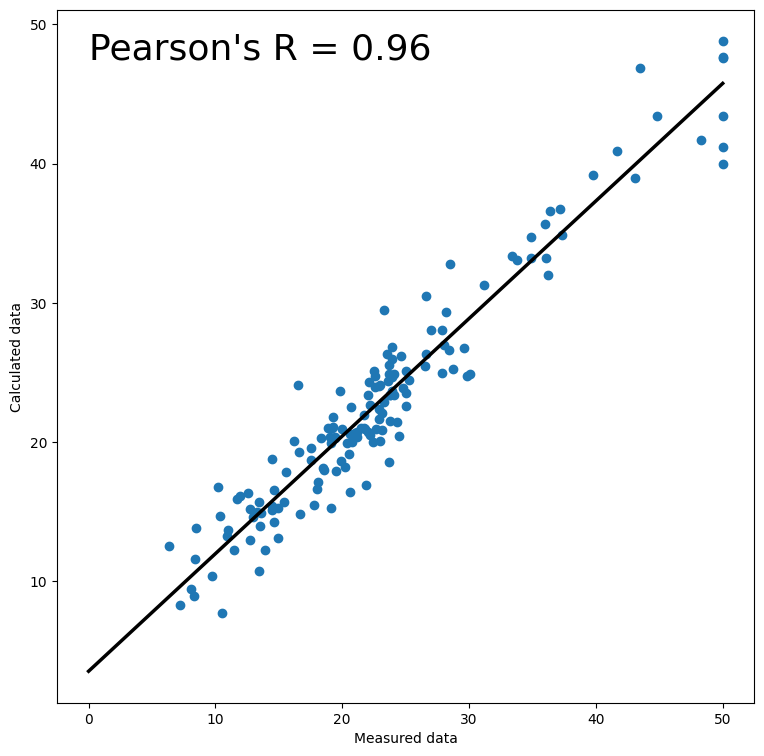

In [19]:
adaBoost_model_tuned = ensemble.GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5).fit(X_train,y_train)
# use plotter function
tuned_mode_plotter(adaBoost_model_tuned)

Finally, I'll visualize a feature importance plot.

Text(0.5, 0, 'Importance of Features')

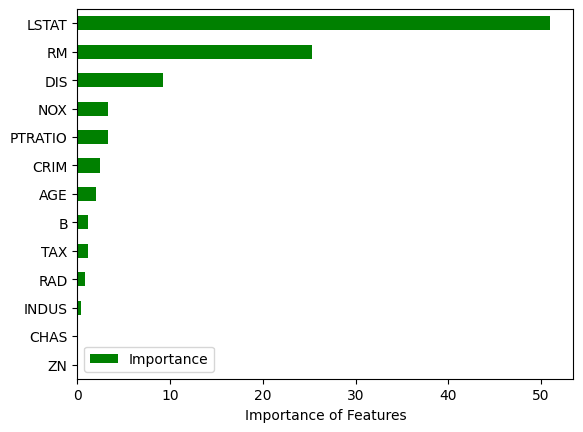

In [20]:
# create dataframe from feauture importance parameter
importance = pd.DataFrame(
    {"Importance": adaBoost_model.feature_importances_ * 100},
    index = X_train.columns
    )
# plot frequency diagram
importance.sort_values(by="Importance", axis=0, ascending=True).plot(kind="barh", color="green")
plt.xlabel("Importance of Features")

### 12. Extreme Gradient Boosting (XGBoost)
- XGBoost is an implementation of Gradient Boosting.
- Decision trees are created in sequential form.

In [21]:
# call and train model
xgb_model = XGBRegressor().fit(X_train, y_train)
# make a prediction
y_pred = xgb_model.predict(X_test)
# print performance metrics
print("Test data - MSE: ", metrics.mean_squared_error(y_pred, y_test))
print("Test data - RMSE: ", np.sqrt(metrics.mean_squared_error(y_pred, y_test)))

Test data - MSE:  9.772434127636975
Test data - RMSE:  3.1260892705802523


XGBoost has several hyperparameters, which can be collected into three bigger groups:
- General Parameters - These parameters guide the overall functioning of the XGBoost model.
- Booster Parameters - 2 types of boosters. Tree booster and linear booster (tree booster outperforms the linear booster).
- Learning Task Parameter - These parameters are used to define the optimization objective the metric to be calculated at each step.

I'll tune the lcolsample_bytree, learning_rate, max_depth, n_estimators hyperparameters.

In [22]:
# sample space
xgb_params = {
    "colsample_bytree": [0.4, 0.5],
    "learning_rate": [0.1, 0.01],
    "max_depth": [2, 3],
    "n_estimators": [100, 200]
}
# call GridSearch and apply it on model space
xgb_gridSearch = model_selection.GridSearchCV(xgb_model, xgb_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)
# print optimal hyperparameters
xgb_gridSearch.best_params_

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.4, learni

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 200}

Test data - MSE:  10.125955468681541
Test data - RMSE:  3.182130649216267
Test data - Pearson's R:  0.9445862761590949


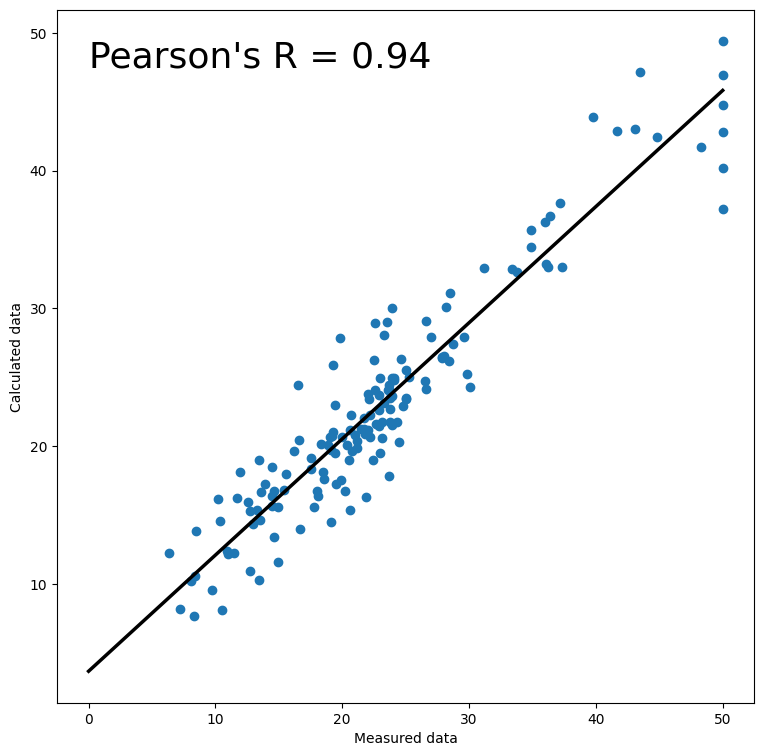

In [23]:
xgb_model_tuned = XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200).fit(X_train, y_train)
# use plotter function
tuned_mode_plotter(xgb_model_tuned)

### 13. Light Gradient Boost Machine (LightGBM)
LightGBM is significantly faster than XGBoost but delivers almost equivalent performance.

In [24]:
# call model and train
lgbm_model = LGBMRegressor().fit(X_train, y_train)
# make a prediction with default parameters
y_pred = lgbm_model.predict(X_test)
# print performance metrics
print("Test data - MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("Test data - RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test data - MSE:  9.609855482507486
Test data - RMSE:  3.0999766906393806


I'll tune the lcolsample_bytree, learning_rate, max_depth, n_estimators hyperparameters.

In [25]:
# sample space
lgbm_param = {
    "learning_rate": [0.01, 0.1],
    "n_estimators": [20, 40],
    "max_depth": [1, 2, 3],
    "colsample_bytree": [0.4, 0.5]
}
# cal and train GridSearch
lgbm_gridSearch = model_selection.GridSearchCV(lgbm_model, lgbm_param, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)
# print optimal hyperparameters
lgbm_gridSearch.best_params_

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END colsample_bytree=0.4, learning_rate=0.01, max_depth=1, n_estimators=20; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.01, max_depth=1, n_estimators=40; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.01, max_depth=1, n_estimators=40; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.01, max_depth=1, n_estimators=20; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.01, max_depth=1, n_estimators=20; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.01, max_depth=1, n_estimators=20; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.01, max_depth=1, n_estimators=20; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.01, max_depth=1, n_estimators=40; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.01, max_depth=1, n_estimators=40; total time=   0.0s
[CV] END colsample_bytree=0.4, learni

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 40}

Test data - MSE:  11.520162030777179
Test data - RMSE:  3.3941364189992687
Test data - Pearson's R:  0.9407685545918432


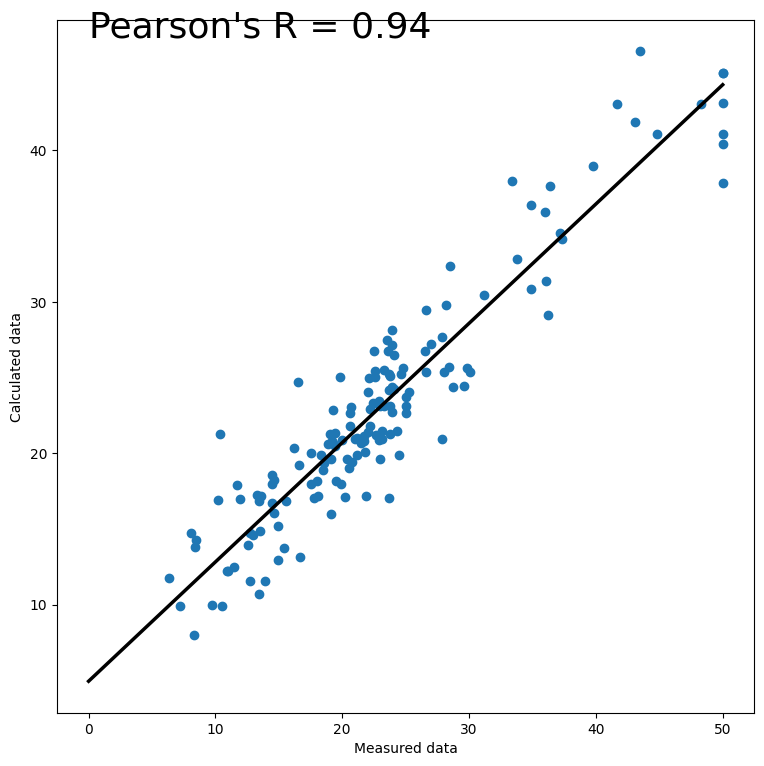

In [26]:
lgbm_model_tuned = LGBMRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=40).fit(X_train, y_train)
# use plotter function
tuned_mode_plotter(lgbm_model_tuned)

### 14. Categorical Boosting (CatBoost)
- CatBoost is an alternative to XGBoost.
- Can handle categorical features directly without encoding.

In [27]:
# call model
categoricalBoost = CatBoostRegressor()
# train model
categoricalBoost_model = categoricalBoost.fit(X_train, y_train)

Learning rate set to 0.034747
0:	learn: 8.8589352	total: 48.3ms	remaining: 48.3s
1:	learn: 8.6835131	total: 49ms	remaining: 24.5s
2:	learn: 8.5183964	total: 49.6ms	remaining: 16.5s
3:	learn: 8.3726939	total: 50.2ms	remaining: 12.5s
4:	learn: 8.2325333	total: 50.7ms	remaining: 10.1s
5:	learn: 8.1034567	total: 51.1ms	remaining: 8.47s
6:	learn: 7.9732383	total: 51.6ms	remaining: 7.32s
7:	learn: 7.8374744	total: 52.1ms	remaining: 6.46s
8:	learn: 7.7019703	total: 52.6ms	remaining: 5.79s
9:	learn: 7.5435282	total: 53.1ms	remaining: 5.25s
10:	learn: 7.4024317	total: 53.5ms	remaining: 4.81s
11:	learn: 7.2761529	total: 54ms	remaining: 4.45s
12:	learn: 7.1427295	total: 54.5ms	remaining: 4.13s
13:	learn: 7.0112960	total: 56ms	remaining: 3.94s
14:	learn: 6.8985189	total: 57.4ms	remaining: 3.77s
15:	learn: 6.7723068	total: 58.2ms	remaining: 3.58s
16:	learn: 6.6567722	total: 58.7ms	remaining: 3.4s
17:	learn: 6.5512510	total: 60.1ms	remaining: 3.28s
18:	learn: 6.4404943	total: 60.9ms	remaining: 3.14s

In [28]:
# make prediction
y_pred = categoricalBoost_model.predict(X_test)
# print performance metics
print("Test data - MSE: ", metrics.mean_squared_error(y_pred, y_test))
print("Test data - RMSE: ", np.sqrt(metrics.mean_squared_error(y_pred, y_test)))

Test data - MSE:  8.117085909329525
Test data - RMSE:  2.8490500011985618


I'll tune the learning_rate, depth, iterations hyperparameters.

In [29]:
# sample space
catb_params = {
    "learning_rate": [0.01, 0.03],
    "iterations": [200, 1000],
    "depth":[3, 4]
}
# call CatBoost regressor and GridSearch
catB = CatBoostRegressor()
catb_cv_model = model_selection.GridSearchCV(catB, catb_params, cv=10, verbose=2, n_jobs=-1)
# apply GridSearch
catb_cv_model.fit(X_train, y_train)
# print optimal hyperparameters
catb_cv_model.best_params_


Fitting 10 folds for each of 8 candidates, totalling 80 fits
0:	learn: 9.0732711	total: 49ms	remaining: 9.74s
1:	learn: 9.0186350	total: 49.2ms	remaining: 4.87s
2:	learn: 8.9756863	total: 49.4ms	remaining: 3.24s
3:	learn: 8.9309866	total: 49.6ms	remaining: 2.43s
0:	learn: 8.9040431	total: 47.8ms	remaining: 9.51s
4:	learn: 8.8806359	total: 49.7ms	remaining: 1.94s
5:	learn: 8.8308412	total: 49.9ms	remaining: 1.61s
1:	learn: 8.7421910	total: 48ms	remaining: 4.75s
6:	learn: 8.7863428	total: 50ms	remaining: 1.38s
2:	learn: 8.6206825	total: 48.2ms	remaining: 3.16s
7:	learn: 8.7386682	total: 50.1ms	remaining: 1.2s
3:	learn: 8.4859651	total: 48.3ms	remaining: 2.37s
4:	learn: 8.3535926	total: 48.5ms	remaining: 1.89s
8:	learn: 8.6910789	total: 50.5ms	remaining: 1.07s
9:	learn: 8.6504860	total: 50.7ms	remaining: 962ms
5:	learn: 8.2264583	total: 48.9ms	remaining: 1.58s
10:	learn: 8.6039027	total: 50.8ms	remaining: 873ms
11:	learn: 8.5640238	total: 51ms	remaining: 798ms
6:	learn: 8.1082391	total: 4

{'depth': 4, 'iterations': 1000, 'learning_rate': 0.03}

0:	learn: 8.8762586	total: 340us	remaining: 341ms
1:	learn: 8.7302392	total: 817us	remaining: 408ms
2:	learn: 8.5610235	total: 1.23ms	remaining: 409ms
3:	learn: 8.4181361	total: 1.49ms	remaining: 372ms
4:	learn: 8.2809001	total: 1.77ms	remaining: 353ms
5:	learn: 8.1410474	total: 2.05ms	remaining: 340ms
6:	learn: 7.9991821	total: 2.24ms	remaining: 318ms
7:	learn: 7.8664720	total: 2.49ms	remaining: 309ms
8:	learn: 7.7386886	total: 2.77ms	remaining: 305ms
9:	learn: 7.6129487	total: 3.04ms	remaining: 301ms
10:	learn: 7.5059431	total: 3.29ms	remaining: 296ms
11:	learn: 7.3919286	total: 3.53ms	remaining: 291ms
12:	learn: 7.2715787	total: 3.78ms	remaining: 287ms
13:	learn: 7.1773027	total: 4.03ms	remaining: 284ms
14:	learn: 7.0879922	total: 4.31ms	remaining: 283ms
15:	learn: 6.9878844	total: 4.52ms	remaining: 278ms
16:	learn: 6.8818568	total: 4.74ms	remaining: 274ms
17:	learn: 6.7702958	total: 5.06ms	remaining: 276ms
18:	learn: 6.6766433	total: 5.5ms	remaining: 284ms
19:	learn: 6.5952680	tota

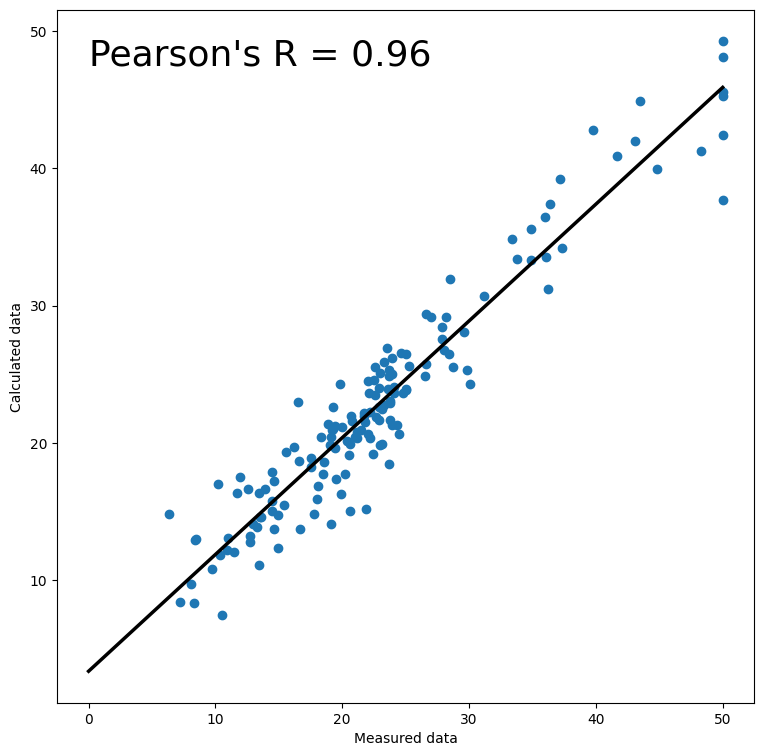

In [30]:
categoricalBoost_tuned = CatBoostRegressor(depth=4, iterations=1000, learning_rate=0.03).fit(X_train, y_train)
# use plotter function
tuned_mode_plotter(categoricalBoost_tuned)

### 15. Artifical Nural Notwork (ANN)
Multi-layer Perceptron regressor. This model optimizes the squared error using LBFGS or stochastic gradient descent.

In [31]:
# import Standard Scaler
scaler = preprocessing.StandardScaler().fit(X_train)
# Scale train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# call MLP and train
mlp_model = neural_network.MLPRegressor(hidden_layer_sizes=(100,20)).fit(X_train_scaled, y_train)
# print MLP architecture
print("Number of layers: ", mlp_model.n_layers_)
print("Hidden layer sizes: ", mlp_model.hidden_layer_sizes)

Number of layers:  4
Hidden layer sizes:  (100, 20)


/home/znagy2/ds_az/eda_ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [33]:
# make a prediction with the default model
y_pred = mlp_model.predict(X_test_scaled)
# print performance metrics
print("Test data - MSE: ", metrics.mean_squared_error(y_pred, y_test))
print("Test data - RMSE: ", np.sqrt(metrics.mean_squared_error(y_pred, y_test)))

Test data - MSE:  12.917576113204413
Test data - RMSE:  3.594102963634238


I'll tune the alpha, hidden_layer_sizes, activation hyperparameters.

In [34]:
# sample space
mlp_params = {
    "alpha":[0.1,0.01],
    "hidden_layer_sizes":[(20,20),(100,50,)],
    "activation":["relu","logistic"]
}
# use GridSearch to find optimal hyperparameters
mlp_gridSearch = model_selection.GridSearchCV(mlp_model, mlp_params, cv=10).fit(X_train_scaled,y_train)
# print optimal hyperparameter values
mlp_gridSearch.best_params_

/home/znagy2/ds_az/eda_ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/znagy2/ds_az/eda_ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/znagy2/ds_az/eda_ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/znagy2/ds_az/eda_ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/znagy2/ds_az/eda_ml/li

{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50)}